# Phase 3 - Modeling

This code is collaboratively worked by following students:

Zirui Zheng, ziruizhe

Keyu Zhang, keyuzhan

David Lee, dlee3

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Load regressors
# ----------------
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
loan_status = list(data['loan_status'])
#print(loan_status[0:3])

outcome = [True if i == 'Charged Off' or i=='Default' else False for i in loan_status]
data["outcome"] = outcome
#f(x) if condition else g(x) for x in sequence
#data['outcome']

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice(2,data.shape[0],p=[0.3,0.7])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [10]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [11]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        y_test_2 = [0 if i == True else 1 for i in y_test]
        fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output("{} ::search_on_edge".format(model_name), opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [12]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'loan_length', 'term_num',
       'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'outcome', 'cr_hist']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: GNB
Fit time: 0.23 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.0
Accuracy:  0.7962
             precision    recall  f1-score   support

 No default     0.1429    0.0005    0.0010      4066
    Default     0.7967    0.9992    0.8865     15934

avg / total     0.6637    0.7962    0.7065     20000



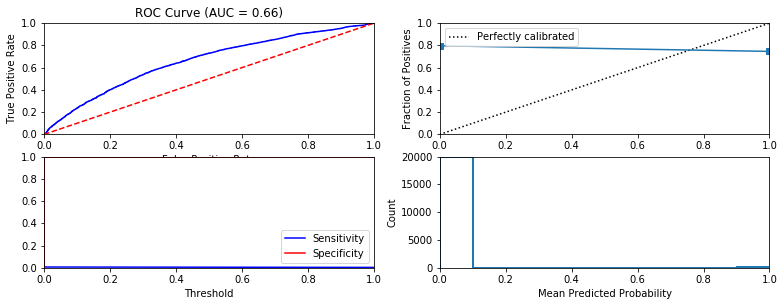


Similarity to LC grade ranking:  -0.5969939091015618
Brier score: 0.7950484276493014
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.2008]


In [13]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb,data_dict,model_name='GNB')

### $l_1$ regularized logistic regression

  Model: l1_logistic
Fit time: 21.53 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4971211268475009
Accuracy:  0.79855
             precision    recall  f1-score   support

 No default     0.5939    0.0288    0.0549      4066
    Default     0.8006    0.9950    0.8873     15934

avg / total     0.7586    0.7985    0.7180     20000



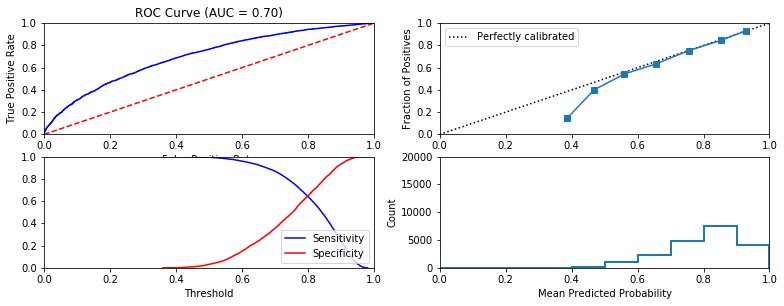


Similarity to LC grade ranking:  -0.7443455225530414
Brier score: 0.1481175262652717
Were parameters on edge? : False
Score variations around CV search grid : 0.1161295674173624
[0.80283333 0.80283333 0.8037     0.80276667 0.8029     0.80283333]


In [14]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':[0.001,0.01,0.1,1,10,100]}

l1_logistic = fit_classification(l1_logistic,data_dict, cv_parameters= cv_parameters, model_name='l1_logistic')

### $l_2$ regularized logistic regression

  Model: l2_logistic
Fit time: 4.26 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.523279350373715
Accuracy:  0.79815
             precision    recall  f1-score   support

 No default     0.5438    0.0443    0.0819      4066
    Default     0.8024    0.9905    0.8866     15934

avg / total     0.7499    0.7982    0.7230     20000



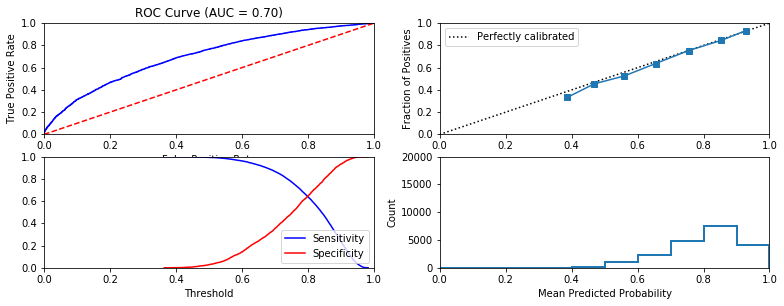


Similarity to LC grade ranking:  -0.7343433122457506
Brier score: 0.14833562835401523
Were parameters on edge? : False
Score variations around CV search grid : 0.06638728683457769
[0.80283333 0.80296667 0.80336667 0.803      0.80286667 0.80296667]


In [15]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':[0.001,0.01,0.1,1,10,100]}

l2_logistic = fit_classification(l2_logistic,data_dict, cv_parameters= cv_parameters, model_name='l2_logistic')

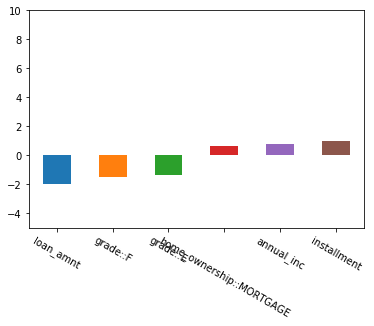

In [16]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: DT
Fit time: 23.95 seconds
Optimal parameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}

Accuracy-maximizing threshold was: 0.5151515151515151
Accuracy:  0.78595
             precision    recall  f1-score   support

 No default     0.4176    0.1340    0.2029      4066
    Default     0.8117    0.9523    0.8764     15934

avg / total     0.7316    0.7860    0.7395     20000



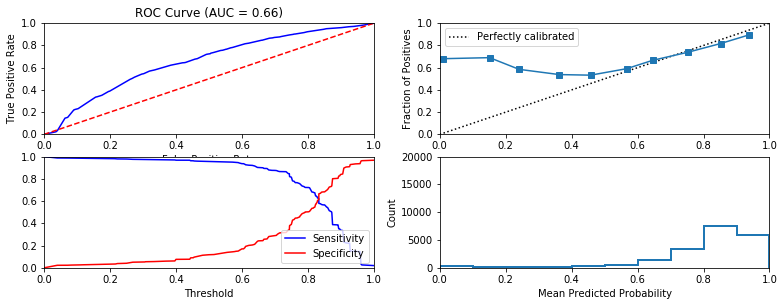


Similarity to LC grade ranking:  -0.5725675246652869
Brier score: 0.16513699919451794
Were parameters on edge? : True
Score variations around CV search grid : 12.581713218439594
[0.785      0.78526667 0.78503333 0.7837     0.78396667 0.78436667
 0.78376667 0.78376667 0.78376667 0.7014     0.69506667 0.69536667
 0.689      0.68646667 0.6901     0.70533333 0.7048     0.705
 0.70183333 0.69596667 0.69346667 0.68723333 0.68676667 0.68843333
 0.70533333 0.70326667 0.70326667]


In [17]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':[10,30,50],
                 'min_samples_split': [2,4,6],
                 'min_samples_leaf':[1,2,3]
                }

decision_tree = fit_classification(decision_tree,data_dict, cv_parameters= cv_parameters, model_name='DT')

### Random forest

  Model: RF
Fit time: 368.13 seconds
Optimal parameters:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.32155470679675957
Accuracy:  0.7735
              precision    recall  f1-score   support

  No default     0.8297    0.9006    0.8637     15934
     Default     0.4142    0.2755    0.3309      4066

   micro avg     0.7735    0.7735    0.7735     20000
   macro avg     0.6219    0.5880    0.5973     20000
weighted avg     0.7452    0.7735    0.7554     20000



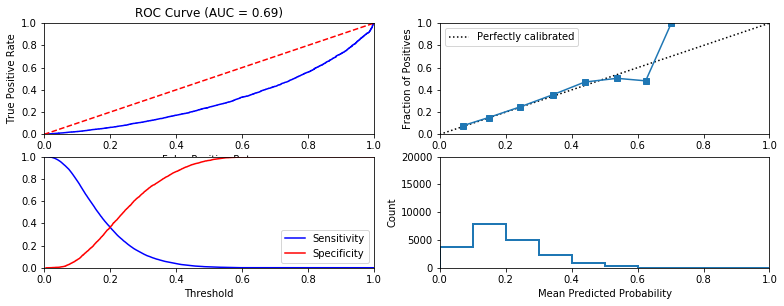


Similarity to LC grade ranking:  0.5353088137045665
Brier score: 0.14987450976294034
Were parameters on edge? : True
Score variations around CV search grid : 1.5440810227461494
[0.80216667 0.80276667 0.80203333 0.803      0.8025     0.8028
 0.80256667 0.80283333 0.80193333 0.8027     0.80266667 0.80283333
 0.80236667 0.803      0.803      0.80263333 0.79576667 0.80156667
 0.7955     0.8021     0.79973333 0.80216667 0.79983333 0.80223333
 0.79423333 0.8018     0.79626667 0.8022     0.8007     0.80273333
 0.8014     0.80256667 0.80213333 0.80276667 0.80216667 0.80273333
 0.80266667 0.80256667 0.80213333 0.8026     0.802      0.80263333
 0.8029     0.80296667 0.8028     0.80276667 0.8026     0.80246667
 0.79153333 0.80003333 0.79313333 0.80136667 0.80126667 0.80306667
 0.79966667 0.80273333 0.79066667 0.7991     0.7942     0.8022
 0.7992     0.80266667 0.80093333 0.8028    ]


In [13]:
## Train and test a random forest classifier
random_forest = RandomForestClassifier()
cv_parameters = {'bootstrap': [True, False],
 'max_depth': [10,50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 10],
 'n_estimators': [10, 100]}

random_forest = fit_classification(random_forest,data_dict, cv_parameters= cv_parameters, model_name='RF')

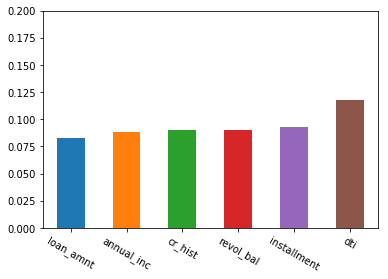

In [19]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLP
Fit time: 405.61 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 1), 'learning_rate': 'constant'}

Accuracy-maximizing threshold was: 0.5564103011448778
Accuracy:  0.79655
             precision    recall  f1-score   support

 No default     0.4967    0.0563    0.1012      4066
    Default     0.8036    0.9854    0.8853     15934

avg / total     0.7412    0.7965    0.7259     20000



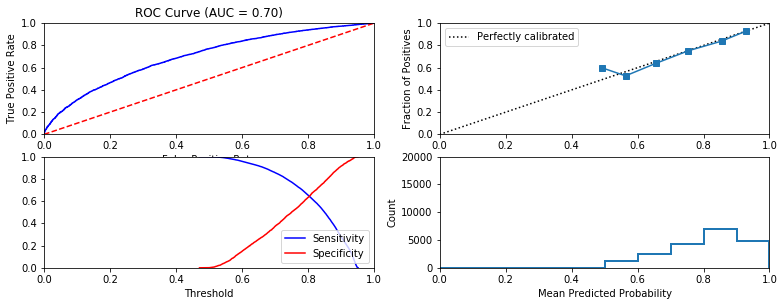


Similarity to LC grade ranking:  -0.74069721210267
Brier score: 0.1484983977184756
Were parameters on edge? : True
Score variations around CV search grid : 2.2650902302426874
[0.80263333 0.8024     0.8035     0.80276667 0.80196667 0.80223333
 0.80303333 0.80343333 0.79516667 0.79596667 0.7945     0.78986667
 0.79683333 0.79986667 0.7853     0.79276667]


In [20]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'activation':['tanh', 'relu'],
                'learning_rate':['constant', 'invscaling'],
                'alpha':[0.001,0.01],
                'hidden_layer_sizes':[(50,1),(100,1)]}

mlp = fit_classification(mlp,data_dict, cv_parameters= cv_parameters, model_name='MLP')

## Train and Test logistic regression model with features derived by LendingClub

In [21]:
# derived features: dti, grade
# features correlated with above two: annual_inc, installment, loan_amnt

In [22]:
def fit_classification_avg(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    report = classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4)
    
    if print_to_screen:
        
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(report)
        
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output("{} ::search_on_edge".format(model_name), opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out,report

In [23]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['dti']
weighted_avg_f1 = []
for i in range(100):
    data_dict = prepare_data(feature_subset = a_lendingclub_feature, random_state = i)
    lc1_only_logistic = LogisticRegression(penalty='l1')
    cv_parameters = {'C':[0.001,0.01,0.1,1,10,100]}
    lc1_only_logistic, reg_report = fit_classification_avg(lc1_only_logistic,data_dict, print_to_screen = False,
                                                      cv_parameters= cv_parameters, model_name='1c1_only_logistic')
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [24]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.067109


The std of weighted average f1-score across 100 splits is: 0.0017601758434883706


In [25]:
## train a l2-regularized logistic regression model on data with only that feature
weighted_avg_f1 = []

for i in range(100):
    data_dict = prepare_data(feature_subset = a_lendingclub_feature, random_state = i)
    lc2_only_logistic = LogisticRegression(penalty='l2')
    cv_parameters = {'C':[0.001,0.01,0.1,1,10,100]}
    lc2_only_logistic,reg_report = fit_classification_avg(lc2_only_logistic,data_dict, print_to_screen = False,
                                                      cv_parameters= cv_parameters, model_name='1c2_only_logistic')
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [26]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.7101149999999998


The std of weighted average f1-score across 100 splits is: 0.0040036077480192795


## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [27]:
your_new_features = ['loan_amnt', 'int_rate', 'installment',
       'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose','earliest_cr_line', 'open_acc', 'pub_rec',
       'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'loan_length', 'term_num',
       'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'outcome', 'cr_hist']


In [28]:
# Naive Bayes
weighted_avg_f1 = []

for i in range(100):
    data_dict_2 = prepare_data(feature_subset = your_new_features,random_state = i)    
    gnb_new = GaussianNB()    
    cv_parameters = {'C':[0.001,0.01,0.1,1,10,100]}
    gnb_new,reg_report = fit_classification_avg(gnb_new,data_dict_2,model_name='GNB_new',print_to_screen = False)
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [29]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.7101770000000001


The std of weighted average f1-score across 100 splits is: 0.004000046374731171


In [30]:
## L1 regularized logistic regression classifier
weighted_avg_f1 = []
for i in range(100):
    data_dict_2 = prepare_data(feature_subset = your_new_features, random_state = i)
    lc1_logistic_new = LogisticRegression(penalty='l1')
    cv_parameters = {'C':[0.001,0.01,0.1,1,10,100]}
    lc1_logistic_new,reg_report = fit_classification_avg(lc1_logistic_new,data_dict_2, print_to_screen = False, 
                                                      cv_parameters= cv_parameters, model_name='lc1_logistic_new')
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [31]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.183275


The std of weighted average f1-score across 100 splits is: 0.24799471985306462


In [56]:
## L2 regularized logistic regression classifier
weighted_avg_f1 = []
for i in range(100):
    data_dict_2 = prepare_data(feature_subset = your_new_features, random_state = i)
    lc2_logistic_new = LogisticRegression(penalty='l2')
    cv_parameters = {'C':[0.001,0.01,0.1,1,10,100]}
    lc2_logistic_new,reg_report = fit_classification_avg(lc2_logistic_new,data_dict_2, print_to_screen = False,
                                                      cv_parameters= cv_parameters, model_name='lc2_logistic_new')
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [57]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.711268


The std of weighted average f1-score across 100 splits is: 0.004516743959978249


In [58]:
# Decision Tree
weighted_avg_f1 = []
for i in range(100):
    data_dict_2 = prepare_data(feature_subset = your_new_features, random_state = i)
    decision_tree_new = DecisionTreeClassifier()
    cv_parameters = {'max_depth':[10,30,50],
                     'min_samples_split': [2,4,6],
                     'min_samples_leaf':[1,2,3]
                    } 
    decision_tree_new,reg_report = fit_classification_avg(decision_tree_new,data_dict_2, print_to_screen = False,
                                                      cv_parameters= cv_parameters, model_name='decision_tree_new')
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [59]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.724


The std of weighted average f1-score across 100 splits is: 0.003680013586931447


In [60]:
# Random Forest
weighted_avg_f1 = []
for i in range(100):
    data_dict_2 = prepare_data(feature_subset = your_new_features, random_state = i)
    random_forest_new = RandomForestClassifier()
    cv_parameters = {'bootstrap': [True, False],
                     'max_depth': [10,50],
                     'max_features': ['auto', 'sqrt'],
                     'min_samples_leaf': [1, 4],
                     'min_samples_split': [2, 10],
                     'n_estimators': [10, 100]}
    random_forest_new,reg_report = fit_classification_avg(random_forest_new,data_dict_2, print_to_screen = False,
                                                      cv_parameters= cv_parameters, model_name='random_forest_new')
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [61]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.73986


The std of weighted average f1-score across 100 splits is: 0.004188364836066696


In [38]:
## Multi-layer perceptron classifier
weighted_avg_f1 = []
for i in range(100):
    data_dict_2 = prepare_data(feature_subset = your_new_features, random_state = i)
    mlp_new = MLPClassifier()
    cv_parameters = {'activation':['tanh', 'relu'],
                'learning_rate':['constant', 'invscaling'],
                'alpha':[0.001,0.01],
                'hidden_layer_sizes':[(50,1),(100,1)]}
    mlp_new,reg_report = fit_classification_avg(mlp_new,data_dict_2, print_to_screen = False,
                                                      cv_parameters= cv_parameters, model_name='mlp_new')
    weighted_avg_f1.append(float(reg_report.split('\n')[-2].split('    ')[-2]))

In [39]:
print("\n\nThe mean of weighted average f1-score across 100 splits is: " + str(np.mean(np.array(weighted_avg_f1))))
print("\n\nThe std of weighted average f1-score across 100 splits is: " + str(np.std(np.array(weighted_avg_f1))))



The mean of weighted average f1-score across 100 splits is: 0.708518


The std of weighted average f1-score across 100 splits is: 0.00441016800013476


## Time stability test of YOURMODEL

  Model: rf_2010
Fit time: 82.85 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.7982887893621397
Accuracy:  0.8218571428571428
             precision    recall  f1-score   support

 No default     0.1836    0.1301    0.1523       861
    Default     0.8828    0.9189    0.9005      6139

avg / total     0.7968    0.8219    0.8084      7000



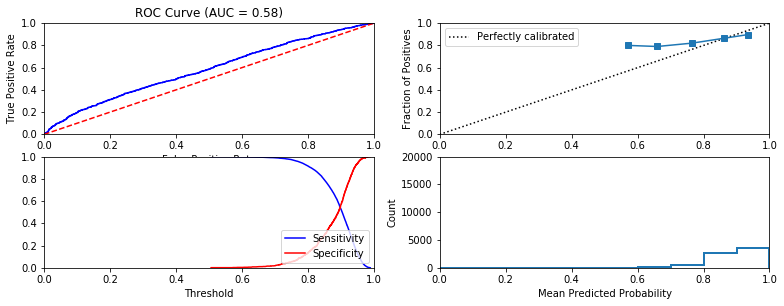


Similarity to LC grade ranking:  -0.35279996068576636
Brier score: 0.10798827776702803
Were parameters on edge? : True
Score variations around CV search grid : 2.950819672131143
[0.90217391 0.9041502  0.9041502  0.9041502  0.9041502  0.9041502
 0.9041502  0.9041502  0.9041502  0.9041502  0.9041502  0.9041502
 0.90019763 0.9041502  0.9041502  0.9041502  0.9041502  0.9041502
 0.9041502  0.9041502  0.9041502  0.90316206 0.9041502  0.9041502
 0.89328063 0.90316206 0.9041502  0.9041502  0.9041502  0.9041502
 0.9041502  0.9041502  0.9041502  0.9041502  0.9041502  0.9041502
 0.89426877 0.9041502  0.90316206 0.89920949 0.9041502  0.9041502
 0.9041502  0.9041502  0.9041502  0.9041502  0.9041502  0.9041502
 0.89624506 0.90316206 0.9041502  0.90316206 0.9041502  0.9041502
 0.9041502  0.9041502  0.9041502  0.9041502  0.9041502  0.9041502
 0.8972332  0.90316206 0.9041502  0.90316206 0.9041502  0.9041502
 0.9041502  0.9041502  0.9041502  0.9041502  0.9041502  0.9041502
 0.90118577 0.9041502  0.9031

In [40]:
# Our model would be random forest with 
# {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

## Define the time window of your train and test data

# First train on 2010 and test on 2017
start_date_train = datetime.date(2010, 1, 1)
end_date_train = datetime.date(2010, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_new_features)

## Train and test YOURMODEL using this data
cv_parameters = {'bootstrap': [True, False],
 'max_depth': [10,50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 10],
 'n_estimators': [10, 100, 200]}

rf_2010 = RandomForestClassifier()
rf_2010 = fit_classification(rf_2010,data_dict_test,cv_parameters= cv_parameters, model_name='rf_2010')

  Model: rf_2016
Fit time: 403.74 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.6817524271465772
Accuracy:  0.7835714285714286
             precision    recall  f1-score   support

 No default     0.2162    0.2973    0.2504       851
    Default     0.8974    0.8509    0.8735      6149

avg / total     0.8146    0.7836    0.7978      7000



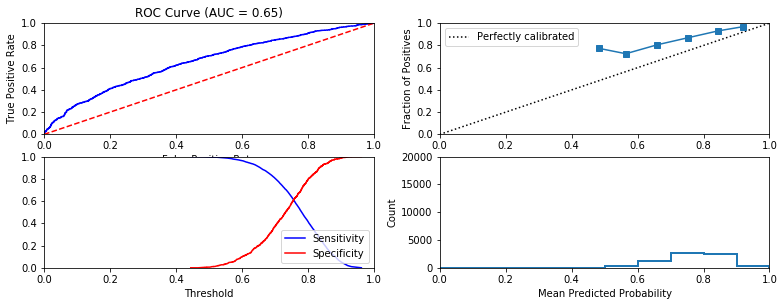


Similarity to LC grade ranking:  -0.352671461247264
Brier score: 0.11646580380069488
Were parameters on edge? : True
Score variations around CV search grid : 6.549008168028003
[0.759      0.76166667 0.76144444 0.75877778 0.76166667 0.76144444
 0.75933333 0.76122222 0.76133333 0.761      0.76133333 0.76155556
 0.75988889 0.76088889 0.76111111 0.76022222 0.761      0.761
 0.76155556 0.76111111 0.76133333 0.75977778 0.76122222 0.76122222
 0.72111111 0.75622222 0.758      0.74877778 0.75866667 0.75988889
 0.75844444 0.76133333 0.76122222 0.759      0.76033333 0.76088889
 0.723      0.75611111 0.75888889 0.75122222 0.75822222 0.76088889
 0.75688889 0.76044444 0.76088889 0.76088889 0.76177778 0.76111111
 0.724      0.75633333 0.75766667 0.74888889 0.75922222 0.76044444
 0.75666667 0.76044444 0.761      0.75766667 0.76155556 0.76066667
 0.71633333 0.75777778 0.75744444 0.74677778 0.75877778 0.75966667
 0.75944444 0.76066667 0.76111111 0.75755556 0.76122222 0.76155556
 0.75922222 0.76088889 0

In [41]:
# Then train on 2016 and test on 2017
start_date_train = datetime.date(2016, 1, 1)
end_date_train = datetime.date(2016, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_new_features)

## Train and test YOURMODEL using this data
cv_parameters = {'bootstrap': [True, False],
 'max_depth': [10,50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 10],
 'n_estimators': [10, 100, 200]}

rf_2016 = RandomForestClassifier()
rf_2016 = fit_classification(rf_2016,data_dict_test,cv_parameters= cv_parameters,model_name='rf_2016')

## Train and test YOURMODEL on the original data

  Model: rf_origin
Fit time: 1478.12 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.6893042385558332
Accuracy:  0.77335
             precision    recall  f1-score   support

 No default     0.4227    0.3141    0.3604      4066
    Default     0.8357    0.8905    0.8623     15934

avg / total     0.7518    0.7733    0.7602     20000



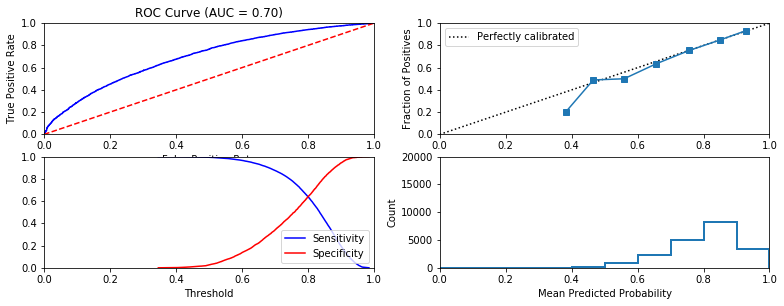


Similarity to LC grade ranking:  -0.5837578911048265
Brier score: 0.1486408673427399
Were parameters on edge? : True
Score variations around CV search grid : 4.05887230514097
[0.80226667 0.80283333 0.80293333 0.8028     0.8025     0.80283333
 0.80316667 0.80276667 0.80296667 0.803      0.80286667 0.803
 0.80283333 0.8029     0.80303333 0.80293333 0.8032     0.8028
 0.8032     0.8029     0.80276667 0.80293333 0.80306667 0.80263333
 0.77606667 0.80066667 0.80196667 0.79736667 0.80193333 0.80343333
 0.80213333 0.8032     0.80376667 0.8009     0.80366667 0.80386667
 0.77526667 0.80226667 0.80166667 0.79613333 0.8034     0.80396667
 0.80116667 0.80356667 0.80373333 0.80163333 0.80393333 0.8036
 0.7762     0.80003333 0.80146667 0.79616667 0.80266667 0.8032
 0.8011     0.80366667 0.804      0.8015     0.803      0.80396667
 0.7745     0.80113333 0.80123333 0.796      0.80223333 0.80386667
 0.80033333 0.80343333 0.80353333 0.8013     0.8038     0.8038
 0.80306667 0.80253333 0.8027     0.8033 

In [42]:
origin_features = ["id", "loan_amnt", "funded_amnt","funded_amnt_inv", "term", "int_rate", "installment", 
                   "grade","sub_grade", "emp_title","emp_length", "home_ownership", "annual_inc", 
                   "verification_status", "issue_d","loan_status", "purpose","title", "zip_code","addr_state",
                   "dti", "delinq_2yrs", "earliest_cr_line", "open_acc", "pub_rec","last_pymnt_amnt",
                   "fico_range_high", "fico_range_low", "last_fico_range_high", "last_fico_range_low",
                   "revol_bal", "revol_util", "total_pymnt","last_pymnt_d", "recoveries","application_type"]

data_origin_dict = prepare_data(feature_subset = origin_features)
cv_parameters = {'bootstrap': [True, False],
 'max_depth': [10,50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 10],
 'n_estimators': [10, 100, 200]}

rf_origin = RandomForestClassifier()
rf_origin = fit_classification(rf_origin,data_origin_dict,cv_parameters= cv_parameters,model_name='rf_origin')

## Test regression models

In [15]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [21]:
## First, trying l1 regularized linear regression with hyper-parameters
reg_lasso = Lasso()
cv_parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000]}
data_dict = prepare_data(feature_subset = your_features)
reg_lasso = fit_regression(reg_lasso,data_dict, model_name = 'L1 Regression',cv_parameters= cv_parameters)

  Model: L1 Regression  Return column: ret_PESS
Fit time: 0.9 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.010960395206092155
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -7.941717211979423
All test scores : [-0.10430654 -0.11259027 -0.11259027 -0.11259027 -0.11259027 -0.11259027
 -0.11259027]
  Model: L1 Regression  Return column: ret_OPT
Fit time: 0.96 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.008191197236078862
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -30.330799243517554
All test scores : [-0.02617225 -0.0341105  -0.0341105  -0.0341105  -0.0341105  -0.0341105
 -0.0341105 ]
  Model: L1 Regression  Return column: ret_INTa
Fit time: 0.9 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.009247835068874055
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -6.612546226965875
All test scores : [-0.093892

### $l_2$ regularized linear regressor

In [45]:
## trying l2 regularized linear regression with hyper-parameters
reg_ridge = Ridge()
cv_parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000]}
reg_ridge = fit_regression(reg_ridge, data_dict, model_name = 'L2 Regression',cv_parameters= cv_parameters)

  Model: L2 Regression  Return column: ret_PESS
Fit time: 2.12 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.02611385404997213
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -8.986407271128392
All test scores : [-0.08600183 -0.0859967  -0.08595131 -0.08572406 -0.08545397 -0.0869259
 -0.09313321]
  Model: L2 Regression  Return column: ret_OPT
Fit time: 1.15 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.01586401097737722
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -33.57918670705293
All test scores : [-0.01824935 -0.01824724 -0.01822638 -0.01813018 -0.01797405 -0.01860964
 -0.02400959]
  Model: L2 Regression  Return column: ret_INTa
Fit time: 1.17 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.030692129058595197
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -12.421227515569324
All test scores : [-0.07171519 -0.0

### Multi-layer perceptron regressor

In [46]:
## trying multi-layer perceptron regression with hyper-parameters
reg_mlp = MLPRegressor()
cv_parameters = {'activation':['tanh', 'relu'],
                'learning_rate':['constant', 'invscaling'],
                'alpha':[0.001,0.01],
                'hidden_layer_sizes':[(50,1),(100,1)]}
reg_mlp = fit_regression(reg_mlp,data_dict,model_name = 'Multi-layer Perceptron Regression',cv_parameters= cv_parameters)

  Model: Multi-layer Perceptron Regression  Return column: ret_PESS
Fit time: 83.96 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 1), 'learning_rate': 'constant'}

Testing r2 score: -5.3712793012250515e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -64.59343125503851
All test scores : [-0.13444376 -0.14658576 -0.136787   -0.11532036 -0.15678874 -0.14988465
 -0.10282252 -0.12641132 -0.1385383  -0.16451099 -0.16128695 -0.11691225
 -0.09994991 -0.12361962 -0.10609635 -0.14028992]
  Model: Multi-layer Perceptron Regression  Return column: ret_OPT
Fit time: 92.84 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 1), 'learning_rate': 'invscaling'}

Testing r2 score: -0.0010156163094301451
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -260.87094978916883
All test scores : [-0.03804146 -0.0644244  -0.06134376 -0.0373580

### Random forest regressor

In [23]:
## trying random forest regression with hyper-parameters
reg_rf = RandomForestRegressor()
cv_parameters = {'bootstrap': [True, False],
                 'max_depth': [10,50],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 4],
                 'min_samples_split': [2, 10],
                 'n_estimators': [10, 100]}
reg_rf = fit_regression(reg_rf,data_dict,model_name = "Random Forest Regression",cv_parameters= cv_parameters)

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 1190.98 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Testing r2 score: 0.029817498865867598
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1222.489454387463
All test scores : [-0.10996019 -0.08700836 -0.10984552 -0.08781039 -0.10509953 -0.08741583
 -0.10060643 -0.08791797 -0.09184382 -0.08256569 -0.09183652 -0.08177095
 -0.09179102 -0.08336928 -0.08606573 -0.08207749 -0.20471326 -0.11382742
 -0.17927209 -0.10658255 -0.15398506 -0.09693389 -0.14135398 -0.09778833
 -0.18688826 -0.09407037 -0.1417315  -0.08668702 -0.11445763 -0.08082132
 -0.11296898 -0.08000194 -0.25714979 -0.25569501 -0.24425655 -0.24435544
 -0.24278018 -0.24260187 -0.2397912  -0.2396306  -0.09274205 -0.08285266
 -0.08973476 -0.08244673 -0.09136336 -0.08342271 -0.08819902 -0.08211498
 -1.05801725 -1.

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [16]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        elif strategy == 'Best':
            
            data_test['ret_avg'] = data_test[col_list].mean(axis=1)
            
            # Sort the loans by average return
            data_test = data_test.sort_values(by='ret_avg', ascending = False).reset_index(drop = True)
            
            ## Pick num_loans loans
            pf_test = data_test[:num_loans]
            
            ## Find their return
            ret_test = pf_test[ret_col].mean()
            
            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            
            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            if strategy == 'Best':
                continue;
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [24]:
## Test investment strategies using the best performing regressor
## Our best regressor is random forest regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

avg_return = {"ret_PESS":0,"ret_OPT":0, "ret_INTa":0, "ret_INTb":0}

print('strategy:',test_strategy)
for i in range(100):
    data_strat = prepare_data(feature_subset = your_features, random_state = i)
    strat_def = test_investments(data_strat,
                            classifier = random_forest,
                            regressor = reg_rf,
                            strategy = 'Random', 
                            num_loans = 1000,
                            random_state = default_seed,
                            output_to_file = True)
    for ret_col in col_list:
        avg_return[ret_col] += strat_def[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_return[ret_col]/100))

strategy: Random
ret_PESS: 0.002605928693033101
ret_OPT: 0.04485819291790154
ret_INTa: 0.02196092891663938
ret_INTb: 0.055901681216525584


In [25]:
test_strategy = 'Default-based'

avg_return = {"ret_PESS":0,"ret_OPT":0, "ret_INTa":0, "ret_INTb":0}

print('strategy:',test_strategy)
for i in range(100):
    data_strat = prepare_data(feature_subset = your_features, random_state = i)
    strat_def = test_investments(data_strat,
                            classifier = random_forest,
                            regressor = reg_rf,
                            strategy = 'Default-based', 
                            num_loans = 1000,
                            random_state = default_seed,
                            output_to_file = True)
    for ret_col in col_list:
        avg_return[ret_col] += strat_def[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_return[ret_col]/100))

strategy: Default-based
ret_PESS: 0.00590625086120723
ret_OPT: 0.04520465873530157
ret_INTa: 0.020678365387412096
ret_INTb: 0.05653889227506131


In [26]:
test_strategy = 'Return-based'

avg_return = {"ret_PESS":0,"ret_OPT":0, "ret_INTa":0, "ret_INTb":0}

print('strategy:',test_strategy)
for i in range(100):
    data_strat = prepare_data(feature_subset = your_features, random_state = i)
    strat_def = test_investments(data_strat,
                            classifier = random_forest,
                            regressor = reg_rf,
                            strategy = 'Return-based', 
                            num_loans = 1000,
                            random_state = default_seed,
                            output_to_file = True)
    for ret_col in col_list:
        avg_return[ret_col] += strat_def[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_return[ret_col]/100))

strategy: Return-based
ret_PESS: 0.016207044345742813
ret_OPT: 0.04414190430595328
ret_INTa: 0.021838605982834703
ret_INTb: 0.05607552725970181


In [17]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'bootstrap': [True, False],
                 'max_depth': [10,50],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 4],
                 'min_samples_split': [2, 10],
                 'n_estimators': [10, 100]}

reg_separate = fit_regression(RandomForestRegressor(),data_dict,model_name = "RF Regression for Default-return",
                              cv_parameters= cv_parameters, separate=True)

  Model: RF Regression for Default-return  Return column: ret_PESS
Fit time: 1155.12 seconds
Optimal parameters:
model_0: {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} model_1 {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Testing r2 scores:
model_0: 0.052246516246102104
model_1: 0.08003739539229027
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -910.4827563260453
All test scores : [-0.1698092  -0.13598225 -0.15963739 -0.13843255 -0.14582559 -0.12557702
 -0.14187687 -0.12603557 -0.14470599 -0.13076047 -0.13822969 -0.12762382
 -0.13271872 -0.12578193 -0.14133305 -0.12828155 -0.26631298 -0.15587277
 -0.21904445 -0.15065555 -0.18243635 -0.11913961 -0.17271162 -0.12177785
 -0.23534487 -0.13156525 -0.17397209 -0.12532126 -0.15789738 -0.11964298
 -0.15007751 -0.11855882 -0.34406318 -

In [20]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
avg_return = {"ret_PESS":0,"ret_OPT":0, "ret_INTa":0, "ret_INTb":0}

print('strategy:',test_strategy)
for i in range(100):
    data_strat = prepare_data(feature_subset = your_features, random_state = i)
    strat_def = test_investments(data_strat,
                            classifier = random_forest,
                            regressor = reg_separate,
                            strategy = 'Default-return-based', 
                            num_loans = 1000,
                            random_state = default_seed,
                            output_to_file = True)
    for ret_col in col_list:
        avg_return[ret_col] += strat_def[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_return[ret_col]/100))

strategy: Default-return-based
ret_PESS: 0.015752234482654413
ret_OPT: 0.04540471983997473
ret_INTa: 0.02106111041303344
ret_INTb: 0.05589658989640936


In [54]:
test_strategy = 'Best'

print('strategy:',test_strategy)
strat_def = test_investments(data_strat,
                        strategy = 'Best', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Best
ret_PESS: 0.08594754603451737
ret_OPT: 0.17215684170370957
ret_INTa: 0.1007533312901027
ret_INTb: 0.143604165763524


## Sensitivity test of portfolio size

#### Both Default-return-based and Return-based models look good to us

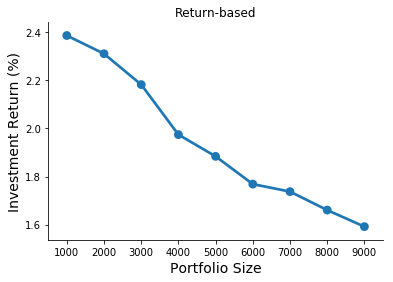

In [30]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):
    ret = 0
    for i in range(100):
        data_sense = prepare_data(feature_subset = your_features, random_state = i)
        reg_0 = test_investments(data_sense,
                                classifier = random_forest,
                                regressor = reg_rf,
                                strategy = 'Return-based', 
                                num_loans = num_loans,
                                random_state = default_seed,
                                output_to_file = True)
        ret += reg_0['ret_PESS']['average return']
    result_sensitivity.append(ret/100)
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.title('Return-based')
plt.show()

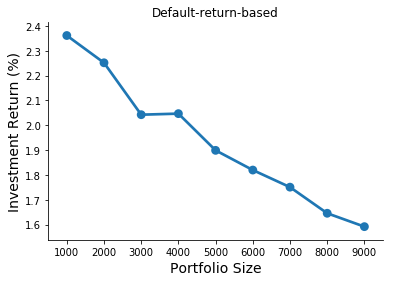

In [29]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):
    ret = 0
    for i in range(100):
        data_sense = prepare_data(feature_subset = your_features, random_state = i)
        reg_0 = test_investments(data_sense,
                                classifier = random_forest,
                                regressor = reg_separate,
                                strategy = 'Default-return-based', 
                                num_loans = num_loans,
                                random_state = default_seed,
                                output_to_file = True)
        ret += reg_0['ret_PESS']['average return']
    result_sensitivity.append(ret/100)
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.title('Default-return-based')
plt.show()

### Notes from the team ###

Computation time limited our hyper-parameter tuning. Initially we tried larger scale of hyper-parameters for all models. For example, we have 

cv_parameters = {'activation':['logistic', 'tanh', 'relu'],
                'learning_rate':['constant', 'invscaling'],
                'alpha':[0.00001,0.0001,0.001,0.01],
                'hidden_layer_sizes':[(50,),(50,1),(100,),(200,),(100,1),(200,1)]}
                
for our MLP model. We also added parameters and re-run the fit_classification() when the optimal hyper-parameter was "on the edge". 

However, even though we used parallel CPU and AWS environment (we tried 5 different computation-oriented and GPU instances and spent quite a lot of money), 100 iterations on MLP or Random Forest still took days to run. After looking for help from TA and reading posts about similar issues on Piazza, we decided to shrink our hyper-parameter choices based on previous experiment results, online suggestions, and empirical experience. Hope this could be considered towards grading. 